![MuJoCo banner](https://raw.githubusercontent.com/google-deepmind/mujoco/main/banner.png)

# <h1><center>Tutorial  <a href="https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/tutorial.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a></center></h1>

This notebook provides an introductory tutorial for [**MuJoCo** physics](https://github.com/google-deepmind/mujoco#readme), using the native Python bindings.

<!-- Copyright 2021 DeepMind Technologies Limited

     Licensed under the Apache License, Version 2.0 (the "License");
     you may not use this file except in compliance with the License.
     You may obtain a copy of the License at

         http://www.apache.org/licenses/LICENSE-2.0

     Unless required by applicable law or agreed to in writing, software
     distributed under the License is distributed on an "AS IS" BASIS,
     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
     See the License for the specific language governing permissions and
     limitations under the License.
-->

# All imports

In [1]:
# Set up GPU rendering.
import distutils.util
import os
import subprocess
# # if subprocess.run('nvidia-smi').returncode:
# #   raise RuntimeError(
# #       'Cannot communicate with GPU. '
# #       'Make sure you are using a GPU Colab runtime. '
# #       'Go to the Runtime menu and select Choose runtime type.')

# # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# # This is usually installed as part of an Nvidia driver package, but the Colab
# # kernel doesn't install its driver via APT, and as a result the ICD is missing.
# # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
# NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
# if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
#   with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
#     f.write("""{
#     "file_format_version" : "1.0.0",
#     "ICD" : {
#         "library_path" : "libEGL_nvidia.so.0"
#     }
# }
# """)

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
  import mujoco.viewer # Also have to import this to trigger the installation of the viewer.
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np
from helper_fns import *

# Graphics and plotting.
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:


/tmp/ipykernel_49190/949449057.py:2: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.util


Installation successful.


# Function and Class Setup


In [2]:
model_path = '../assets/environments/table_push.xml'
model = mujoco.MjModel.from_xml_path(model_path)
data = mujoco.MjData(model)

def set_render_opts(model, viewer):
        # tweak scales of contact visualization elements
        model.vis.scale.contactwidth = 0.025
        model.vis.scale.contactheight = 0.25
        model.vis.scale.forcewidth = 0.05
        model.vis.map.force = 0.3
        # viewer.opt.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True # joint viz
        viewer.opt.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
        viewer.opt.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
        viewer.opt.frame = mujoco.mjtFrame.mjFRAME_SITE
        # Set default camera position
        viewer.cam.distance = 2.5       # Distance from the camera to the scene
        viewer.cam.elevation = -30.0    # y-axis rotation
        viewer.cam.azimuth = 100.0      # z-axis rotation
        viewer.cam.lookat[:] = np.array([0.8, 0.0, 0.0])  # Center of the scene


class controller:
    def __init__(self, model: mujoco.MjModel, data: mujoco.MjData, joint_names, site_name):
        self.model = model
        self.data = data
        self.q_indices = np.array([model.joint(name).qposadr for name in joint_names])
        self.v_indices = np.array([model.joint(name).dofadr for name in joint_names])
        self.ee_site = model.site(site_name).id
        self.jacp = np.zeros((3, model.nv))
        self.jacr = np.zeros((3, model.nv))
        self.joint_names = joint_names
        self.J = np.zeros((6, 6)) # Jacobian is size 6 x num_joints
        # Get joint limits
        self.q_min = model.jnt_range[self.q_indices, 0]
        self.q_max = model.jnt_range[self.q_indices, 1]
        # For plotting, save error
        self.error_history_simple = []
        self.error_history_rel = []
        self.error_history_mj = []
        ## Mujoco error calculation (TEMPORARY)
        self.curr_quat = np.zeros(4)
        self.site_quat_conj = np.zeros(4)
        self.error_quat = np.zeros(4)
        self.error_ori = np.zeros(3)
        self.des_quat = np.zeros(4)

    def FK(self):
        mujoco.mj_forward(self.model, self.data) # mj_fwdPosition Update position
        # Assemble FK from Mujoco state info
        R_curr = self.data.site_xmat[self.ee_site].reshape(3, 3)
        p_curr = self.data.site_xpos[self.ee_site].reshape(3, 1)
        T_curr = np.eye(4)
        T_curr[:3, :3] = R_curr
        T_curr[:3, 3] = p_curr.flatten()
        return T_curr
    
    def set_velocity_control(self, v_desired, damping=1e-4):
        """Apply velocity control to the robot"""
        # if np.linalg.matrix_rank(self.J) < 6:
        #     # singular or near-singular configuration
        #     dq = np.zeros(self.n_joints)
        # else:
        dq = self.diff_IK(v_desired, damping)
        
        self.data.ctrl[:] = dq.reshape(-1)
    
    def reset_pose(self, reset_config=np.zeros((6,1))):
        """Reset robot to desired position, by default home position"""
        self.data.qpos[self.q_indices] = reset_config
        self.data.qvel[self.v_indices] = 0.0
        mujoco.mj_fwdPosition(self.model, self.data)
        self.error_history_rel = []
        self.error_history_simple = []
        self.error_history_mj = []
        # return self.data.qpos[self.q_indices].copy()

    def plot_error(self):
        """Plot error norm history"""
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 3, 1)
        plt.plot(np.linalg.norm(self.error_history_simple, axis=1))
        plt.title("Simple Error Norm")
        plt.xlabel("Iteration")
        plt.ylabel("Error Norm")
        
        plt.subplot(1, 3, 2)
        plt.plot(np.linalg.norm(self.error_history_rel, axis=1))
        plt.title("Relative Error Norm")
        plt.xlabel("Iteration")
        plt.ylabel("Error Norm")

        plt.subplot(1, 3, 3)
        plt.plot(np.linalg.norm(self.error_history_mj, axis=1))
        plt.title("Mujoco Error Norm")
        plt.xlabel("Iteration")
        plt.ylabel("Error Norm")

        plt.tight_layout()
        plt.show()
    

    def IK(self, T_des, method=2, max_iters=500, tol=1e-3, damping=0.01, alpha=0.1):
        if T_des.shape != (4, 4):
            raise ValueError("T_des must be a 4x4 homogeneous transform matrix.")
        
        # FOR TESTING
        pose_des = ht2screw(T_des)

        # __ Initialize from Mujoco state __
        q = self.data.qpos[self.q_indices].copy()
        
        for i in range(max_iters):
            self.data.qpos[self.q_indices] = q              # Update position from previous iteration
            mujoco.mj_fwdPosition(self.model, self.data)    # Update forward kinematics
            T_curr = self.FK()                              # Get current end-effector pose

            ## THREE METHODS OF ERROR CALCULATION
            ## _________________________________________________________________________
            
            ## Compute relative error transform in SE(3) AKA ("Where to move from T_curr to reach T_des?")
            T_err = np.linalg.inv(T_curr) @ T_des # "undo" current pose, then apply desired pose
            # Log of that relative motion to get the single true error-screw
            M_err = MatrixLog6(T_err) # 4x4 se(3)
            # Extract associated screw [ω(3); v(3)] from se(3) matrix
            xi_err = np.concatenate([np.array([M_err[2, 1], M_err[0, 2], M_err[1, 0]]),  M_err[:3, 3]]).reshape(6,1) # from skew matrix
            error_rel = twistbody2space(xi_err, T_curr)

            ## Simple error (subtraction)
            pose_curr = ht2screw(T_curr)
            error_simple = np.subtract(pose_des, pose_curr)

            ## Mujoco error calculation
            # position error
            error_pos = T_curr[:3, 3] - T_des[:3, 3]
            # orientation error            
            mujoco.mju_mat2Quat(self.curr_quat, T_curr[:3, :3].flatten())
            mujoco.mju_mat2Quat(self.des_quat, T_des[:3, :3].flatten())
            mujoco.mju_negQuat(self.site_quat_conj, self.curr_quat)
            mujoco.mju_mulQuat(self.error_quat, self.des_quat, self.site_quat_conj)
            mujoco.mju_quat2Vel(self.error_ori, self.error_quat, 1.0)

            err_mj = np.concatenate([self.error_ori, error_pos]).reshape(6,1)


            # Log the errors
            self.error_history_simple.append(error_simple)
            self.error_history_rel.append(error_rel)
            self.error_history_mj.append(err_mj)

            # For now, use the simple error
            xi_err = error_simple


            if np.linalg.norm(xi_err) < tol:
                print("\n**********************************")
                print(f"IK converged in {i} iterations.")
                print("**********************************\n")
                break
            elif i == max_iters - 1:
                print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
                print(f"IK failed to converge after {max_iters} iterations.")
                print(f"Final error: {xi_err.flatten()}")
                print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")
                break
             
            # Build the 6xn Jacobian
            mujoco.mj_jacSite(self.model, self.data, self.jacp, self.jacr, self.ee_site)
            J_pos = self.jacp[:, self.v_indices]
            J_rot = self.jacr[:, self.v_indices]
            self.J = np.vstack([J_rot, J_pos]).squeeze()

            # Also calculate the manipulability measure
            damping = 1 - np.linalg.det(self.J @ self.J.T)
            # print("damping: ", damping)

            ## _________________________________________________________________________
            # Choose update method (1: Newton-Raphson, 2: Damped LS, 3: Gradient Descent))
            if method == 1:
                # Newton-Raphson
                J_update = np.linalg.pinv(self.J).real
            
            elif method == 2:
                # Damped least squares (Levenberg-Marquardt)
                J_update = self.J.T @ np.linalg.pinv((self.J @ self.J.T) + (damping**2 * np.eye(6))).real
                # J_update = np.linalg.pinv(self.J.T @ self.J + damping**2 * np.eye(6)) @ self.J.T

            elif method == 3:
                # Gradient descent
                J_update =  alpha * self.J.T

            else:
                raise ValueError("Invalid method. Choose 1, 2, or 3.")
            ## _________________________________________________________________________            
            
            delta_q = J_update @ xi_err

            q += delta_q.reshape(6,1)

            # Clamp to joint limits
            q = np.clip(q, self.q_min, self.q_max)

        return q

    def diff_IK(self, v_des, damping):
        """
        Solve differential kinematics to achieve desired end-effector velocity
        v_des: 6D vector [lin_vel, ang_vel] in world frame
        Returns: joint velocities
        """
        # Update position and get Jacobian
        mujoco.mj_fwdPosition(self.model, self.data)
        mujoco.mj_jacSite(self.model, self.data, self.jacp, self.jacr, self.ee_site)

        # Extract Jacobian for our joints
        J_pos = self.jacp[:, self.v_indices]
        J_rot = self.jacr[:, self.v_indices]
        self.J = np.vstack([J_pos, J_rot]).squeeze()

        # Compute velocity error
        v_error = v_des - self.J @ self.data.qvel[self.v_indices].reshape(-1,)

        # Damped Least Squares
        JT = np.linalg.pinv(self.J)
        dv = JT @ np.linalg.solve(self.J @ JT + (damping * np.eye(6)), v_error).reshape(6, 1)

        # Limit joint velocities
        vel_limit = 1.5 # rad/s
        dv = np.clip(dv, -vel_limit, vel_limit)
        
        return dv.reshape(-1)

Initial T:
 [[-0.     0.     1.     0.874]
 [ 0.     1.     0.     0.   ]
 [-1.     0.    -0.     0.83 ]
 [ 0.     0.     0.     1.   ]]
Method 1: Newton-Raphson

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
IK failed to converge after 100 iterations.
Final error: [-2.718  1.081 -0.796 -0.397 -0.155  1.028]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



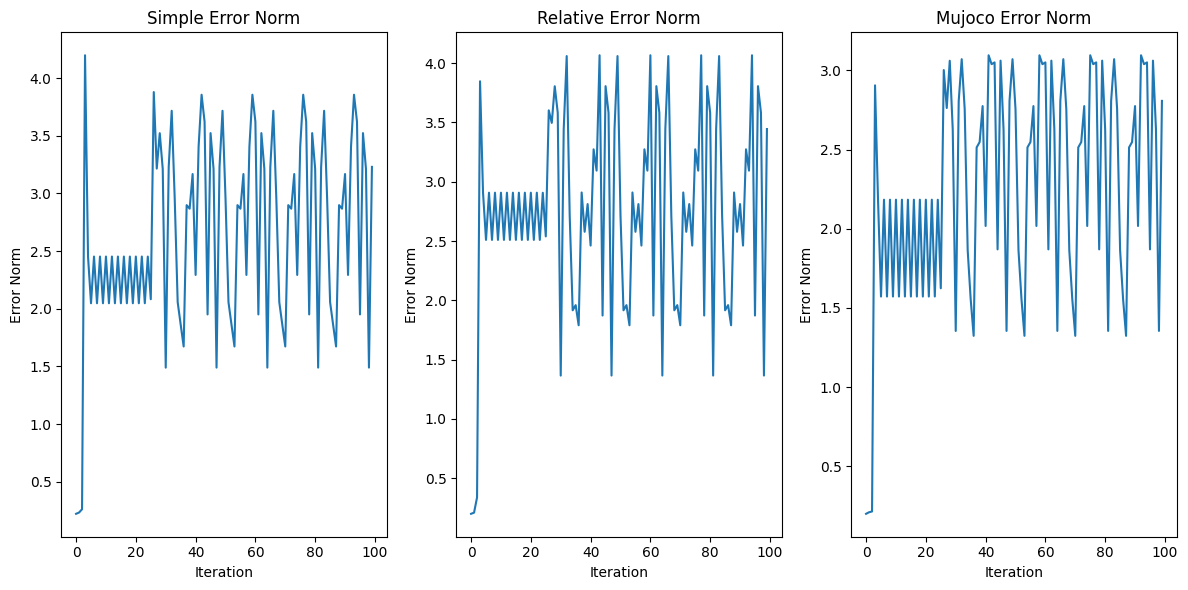

Method 2: Damped Least Squares

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
IK failed to converge after 100 iterations.
Final error: [ 0.     0.007  0.     0.036 -0.     0.076]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



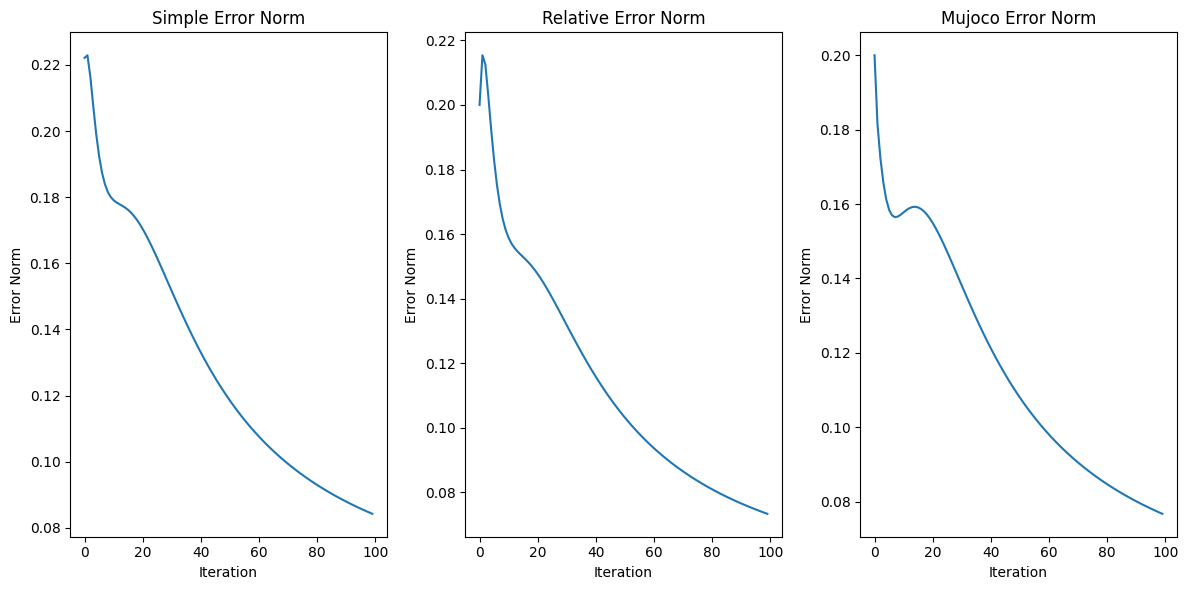

Method 3: Gradient Descent

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
IK failed to converge after 100 iterations.
Final error: [0.    0.01  0.    0.049 0.    0.106]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



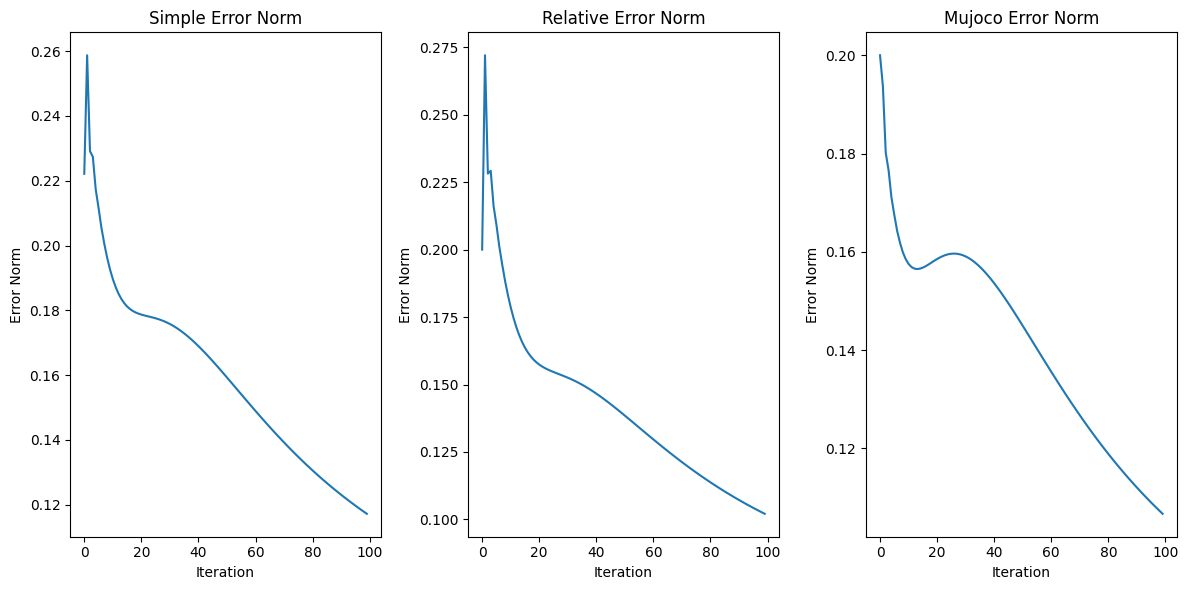

In [5]:
## Let's recall the model to reset the simulation
model = mujoco.MjModel.from_xml_path(model_path)
data = mujoco.MjData(model)
joints = ['joint_1', 'joint_2', 'joint_3', 'joint_4', 'joint_5', 'joint_6']

# Setup based on robot model
irb_controller = controller(model, data, joint_names=joints, site_name='ee_site')

home = irb_controller.FK()


## Through trial and error, we know the following joint configuration yields our desired initial pose:
# q_init = np.array([0.0, 0.525, 0.816, 0.0, -1.33, 0.0]).reshape(6, 1)
T_init = np.array([[-0.011,   0.0,     1.0,     0.844],
                    [   0.0,   1.0,     0.0,     0.0  ],
                    [  -1.0,   0.0,  -0.011,     0.245],
                    [   0.0,   0.0,     0.0,     1.0   ]])

T_init = home.copy()
T_init[2,3] += 0.2 # Move up
print("Initial T:\n", T_init)

## Let's test different IK methods
print("Method 1: Newton-Raphson")
sol_Newton_Raphson = irb_controller.IK(np.array(T_init), method=1, max_iters=100)
irb_controller.plot_error()
irb_controller.reset_pose()


print("Method 2: Damped Least Squares")
sol_Damped_LS = irb_controller.IK(np.array(T_init), method=2, damping=0.9, max_iters=100)
irb_controller.plot_error()
irb_controller.reset_pose()

print("Method 3: Gradient Descent")
sol_Gradient_Descent = irb_controller.IK(np.array(T_init), method=3, alpha=0.5, max_iters=100)
irb_controller.plot_error()
irb_controller.reset_pose()

## FOR VELOCITY CONTROL (format: [vx vy vz wx wy wz])
# target_vel = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])


# with mujoco.viewer.launch_passive(model, data) as viewer:
#     set_render_opts(model, viewer)
    
#     while viewer.is_running():        
#         # irb_controller.set_velocity_control(target_vel)

#         mujoco.mj_step(model, data)
#         viewer.sync()
